# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

/home/pirl/anaconda3/envs/AI/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. 데이터 불러오기

In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 120, 320, 1))
y_train = np.empty((0, 4))

training_data = glob.glob('/home/pirl/Desktop/A4_noruway_code/computer/training_data_up/1556863342.npz')

for single_npz in training_data:
    with np.load(single_npz) as data:
        x = data['train']
        y = data['train_labels']
    x = np.reshape(x, (-1, 120, 320, 1))
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:-1]
y_test = y_test[:,:-1]


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2486763522326790114
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1768226816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15453065556766147189
physical_device_desc: "device: 0, name: Quadro K620, pci bus id: 0000:03:00.0, compute capability: 5.0"
]
(21, 120, 320, 1) (21, 3)
(10, 120, 320, 1) (10, 3)


# 데이터 확인

In [3]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [4]:
#y_data.count()

In [5]:
#left = y_data.loc[y_data[:][0] == 1]

In [6]:
#left.count()

In [7]:
#right = y_data.loc[y_data[:][1] == 1]

In [ ]:
#right.count()

In [ ]:
#forward = y_data.loc[y_data[:][2] == 1]

In [ ]:
#forward.count()

IndexError: index 21 is out of bounds for axis 0 with size 21

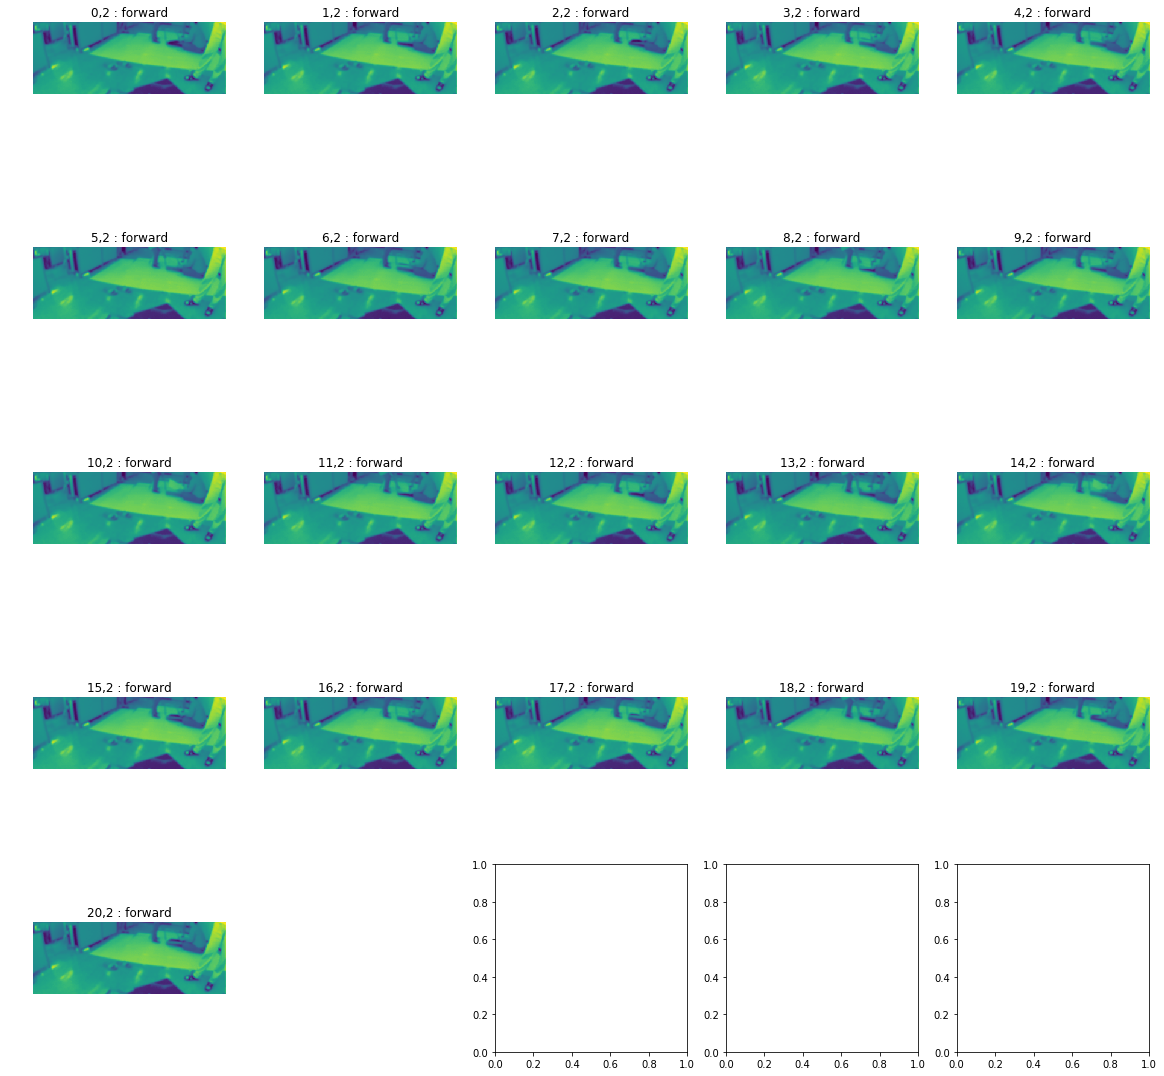

In [23]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (20,20)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(120, 320))
    
    label = np.argmax(y_train[j])
                      
    if label == 0 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 2:
        direction = 'forward'
    elif label == 3:
        direction = 'backward'
                      
    sub_plt_title = str(i) + "," + str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [4]:
# image size = 160 x 320
def posla_net():
    
    # model setting
    H = 120
    W = 320
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [5]:
model = posla_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 318, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 318, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 159, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 157, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 78, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 76, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 38, 18)        0         
__________

In [6]:
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file= 'noru_posla_net_plot.png', show_shapes = True, show_layer_names = True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [7]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [10]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [11]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [12]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 0 samples, validate on 0 samples
Epoch 1/50


AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

In [ ]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['acc'], label="acc")
plt.plot(hist.history['val_acc'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch') 

plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [ ]:
model.save('./model_data/noru_video_model_1.h5')

In [ ]:
#l_model = load_model('./model_data/VGG_model.h5')

In [ ]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

# 7. 최종 모델 훈련

In [ ]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [ ]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [ ]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

In [ ]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

In [ ]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

# 8. 모델 저장

In [ ]:
model.save('./model_data/noru_video_model_2.h5')